# UNET

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torchvision import datasets, transforms

In [ ]:
#define dataset for img and mask
file_dir = "/content/drive/MyDrive/ColabGitHub/s4633131-ISICs-UNET/ISIC2018_Task1-2_Training_Data"
os.chdir(file_dir)

img_path = './ISIC2018_Task1-2_Training_Input_x2'
mask_path = './ISIC2018_Task1_Training_GroundTruth_x2'

imgs = [file for file in sorted(os.listdir(img_path)) if file.endswith('.jpg')]
masks = [file for file in sorted(os.listdir(mask_path)) if file.endswith('.png')]

imgs[0]

'ISIC_0000000.jpg'

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class Unet_dataset(Dataset):
  def __init__(self,
               img_dir = './ISIC2018_Task1-2_Training_Input_x2',
               mask_dir = './ISIC2018_Task1_Training_GroundTruth_x2', 
               img_transforms=None,
               mask_transforms= None):
    
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_transforms = img_transforms
    self.mask_transforms = mask_transforms

    self.imgs = [file for file in sorted(os.listdir(self.img_dir)) if file.endswith('.jpg')]
    self.masks = [file for file in sorted(os.listdir(self.mask_dir)) if file.endswith('.png')]

  #meke dataloader
  def load_img(self, idx):
    img_path = os.path.join(self.img_dir, self.imgs[idx])
    img = Image.open(img_path).convert('RGB')
    return img

  def load_mask(self, idx):
    mask_path = os.path.join(self.mask_dir, self.masks[idx])
    mask = Image.open(mask_path).convert('L')
    return mask

  def __getitem__(self, idx):
    img = self.load_img(idx)
    mask = self.load_mask(idx)

    if self.img_transforms is not None:
      img = self.img_transforms(img)

    if self.mask_transforms is not None:
      mask = self.mask_transforms(mask)

    return img, mask

  def __len__(self):
    return len(self.imgs)

In [ ]:
#img_path = os.path.join(root, "ISIC2018_Task1-2_Training_Input_x2", imgs[idx])
import torchvision.transforms as transforms
img_tfs = transforms.Compose([
                                 transforms.Resize((64,64)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 ]
                                )

mask_tfs = transforms.Compose([
                                 transforms.Resize((64,64)),
                                 transforms.ToTensor(),
                                 ]
                                )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


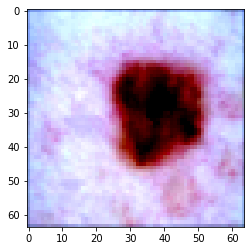

In [ ]:
dataset = Unet_dataset(img_transforms=img_tfs, mask_transforms=mask_tfs)
img, mask = dataset.__getitem__(20)

import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))

(64, 64, 1)

In [ ]:
img_transforms(Image.open(os.path.join(file_dir, img_path, imgs[0])).convert('RGB')).shape

torch.Size([3, 64, 64])

In [ ]:
img_transforms

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [ ]:
class DConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DConv, self).__init__()
    self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride = 1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )

  def forward(self, x):
    return self.conv(x)


class Unet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, feature_size=[64, 128, 256, 512],):
    super(Unet, self).__init__()
    self.downsample = nn.ModuleList()
    self.upsample = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #Downscale part
    for feature in feature_size:
      self.downsample.append(DConv(in_channels, feature))
      in_channels = feature

    #Upscale part
    for feature in reversed(feature_size):
      self.upsample.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride =2))
      self.upsample.append(DConv(feature*2, feature))

    self.bottleneck = DConv(feature_size[-1], feature_size[-1]*2)
    self.final_conv = nn.Conv2d(feature_size[0], out_channels, kernel_size=1)


  def forward(self, x):
    skip_connections = []

    for down in self.downsample:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[: : -1]

    for idx in range(0, len(self.upsample), 2):
      x = self.upsample[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concatnate_skip = torch.cat((skip_connection, x), dim=1)
      x = self.upsample[idx+1](concatnate_skip)
      
    return self.final_conv(x)